In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from pyldl.algorithms import LDL_LRR
from pyldl.utils import LDLEarlyStopping
from pyldl.algorithms.base import BaseGD, BaseDeepLDL
import pyldl.applications.facial_emotion_recognition as fer

In [3]:
import keras
import tensorflow as tf

In [4]:
X, y = fer.load_jaffe('./jaffe/')

In [5]:
train, test = train_test_split(np.arange(X.shape[0]), test_size=0.1, random_state=0)
val = int(train.shape[0] * 0.9)

In [6]:
class LRR(BaseGD, BaseDeepLDL):
    @staticmethod
    def loss_function(y, y_pred):
        return tf.math.reduce_mean(keras.losses.kl_divergence(y, y_pred))

    def _loss(self, X, y, start, end):
        y_pred = self._call(X)
        kld = self.loss_function(y, y_pred)
        rnk = LDL_LRR.ranking_loss(y_pred, self._P[start:end], self._W[start:end]) / (2 * X.shape[0])
        return kld + self._alpha * rnk

    def _before_train(self):
        self._P, self._W = LDL_LRR.preprocessing(self._y)

    def fit(self, X, y, alpha=1e-2, **kwargs):
        self._alpha = alpha
        return super().fit(X, y, **kwargs)

In [7]:
lrr = LRR()

In [8]:
inputs = keras.Input(shape=X.shape[1:])
encodes = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))(inputs)
pooling = keras.layers.GlobalAveragePooling2D()(encodes)
outputs = keras.layers.Dense(y.shape[1], activation='softmax')(pooling)

In [9]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
lrr.fit(X[train][:val], y[train][:val], verbose=1,
        batch_size=32, epochs=500, optimizer=keras.optimizers.SGD(2e-3), model=model,
        X_val=X[train][val:], y_val=y[train][val:], callbacks=[LDLEarlyStopping(monitor='loss', patience=25)])

I0000 00:00:1717573471.672591  176149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/500 [=====>........................] - 151s 1s/step - loss: 0.0336
Epoch 109: early stopping (best loss: 0.03258941322565079).


In [11]:
y_pred = lrr.predict(X[test])

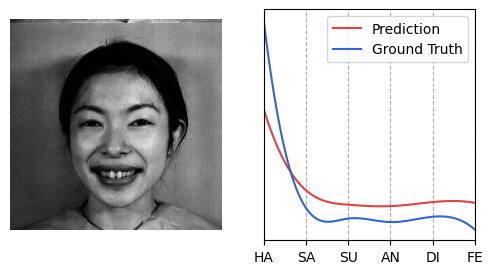

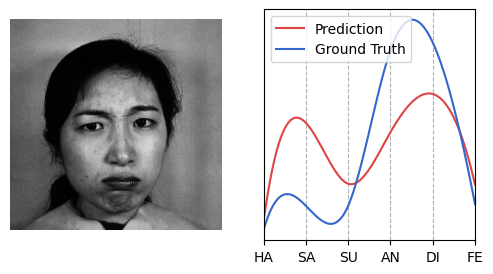

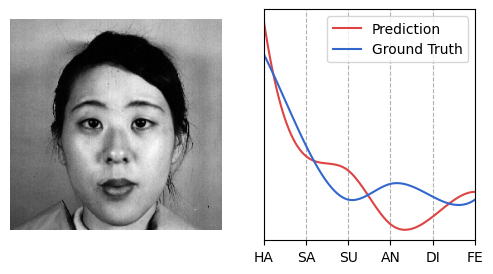

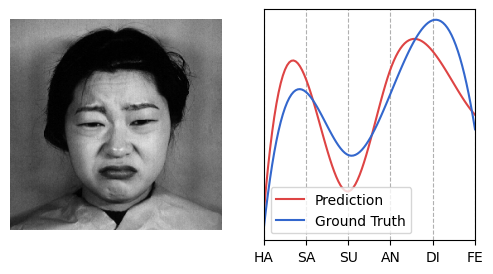

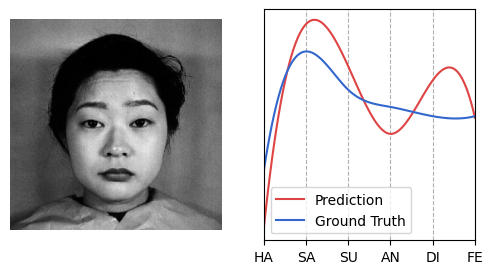

In [12]:
for i in range(5):
    fer.visualization(X[test][i], y_pred[i], y[test][i])

In [13]:
# Windows
# fer.extract_ck_plus('./CK+/', './CK+/features/', './OpenFace_2.2.0_win_x64/')

In [14]:
X, labels, fps, aus = fer.load_ck_plus('./CK+/', './CK+/features/')

In [15]:
y = keras.utils.to_categorical(labels)

In [16]:
train, test = train_test_split(np.arange(X.shape[0]), test_size=0.1, random_state=0)

In [17]:
val = int(train.shape[0] * 0.9)

In [18]:
alsg = fer.LDL_ALSG()

In [19]:
alsg.fit(X[train][:val], y[train][:val], fps, aus, verbose=1,
         batch_size=32, epochs=500, optimizer=keras.optimizers.SGD(2e-5),
         X_val=X[train][val:], y_val=y[train][val:], callbacks=[LDLEarlyStopping(monitor='loss')])

 25/500 [>.............................] - 53s 2s/step - loss: 20.4169
Epoch 25: early stopping (best loss: 20.10953140258789).


In [20]:
y_pred = alsg.predict_proba(X[test])

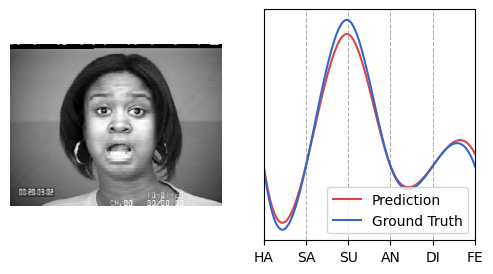

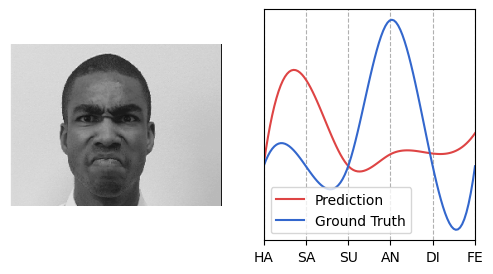

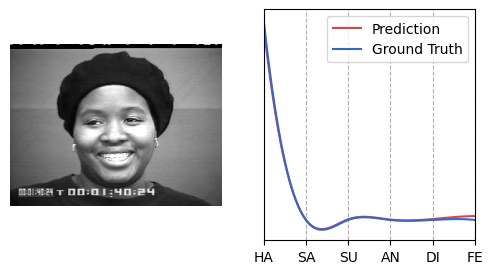

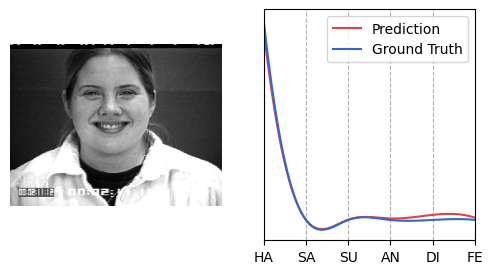

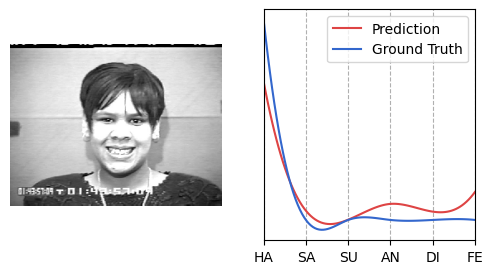

In [21]:
for i in range(5):
    fer.visualization(X[test][i], y_pred[i], y[test][i])